In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
plt.rcParams['figure.figsize'] = [18, 9]

# Load DATASET B&W

(10, 1080, 1920)


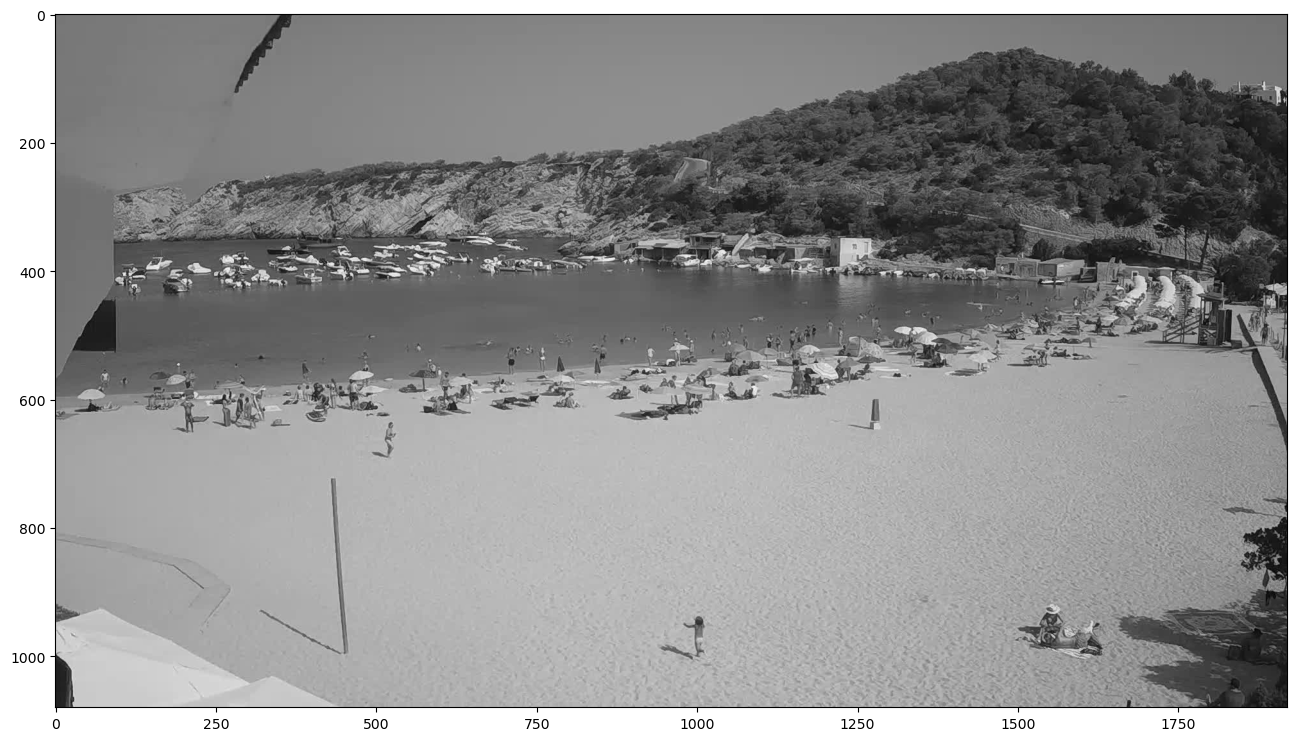

In [3]:
image_filenames = os.listdir("data")
for i in range(len(image_filenames)):
    image_filenames[i] = "data/" + image_filenames[i]

image_stack = np.stack([cv2.imread(filename, cv2.IMREAD_GRAYSCALE) for filename in image_filenames], axis=2)

image_stack = np.transpose(image_stack, (2, 0, 1))

print(image_stack.shape)
plt.imshow(image_stack[0], cmap = "gray")

## Chop mountain, boats and sky

In [4]:
image_mod_9 = image_stack[9].copy()
image_mod_9[0:440,:] = 0

image_mod_4 = image_stack[4].copy()
image_mod_4[0:440,:] = 0

## Clahe histogram transformation

In [5]:
clahe = cv2.createCLAHE(clipLimit=1)

empty_beach_9 = clahe.apply(image_mod_9)

test_image_1 = clahe.apply(image_mod_4)

## Image substraction, between empty and crowded beach 

(-0.5, 1919.5, 1079.5, -0.5)

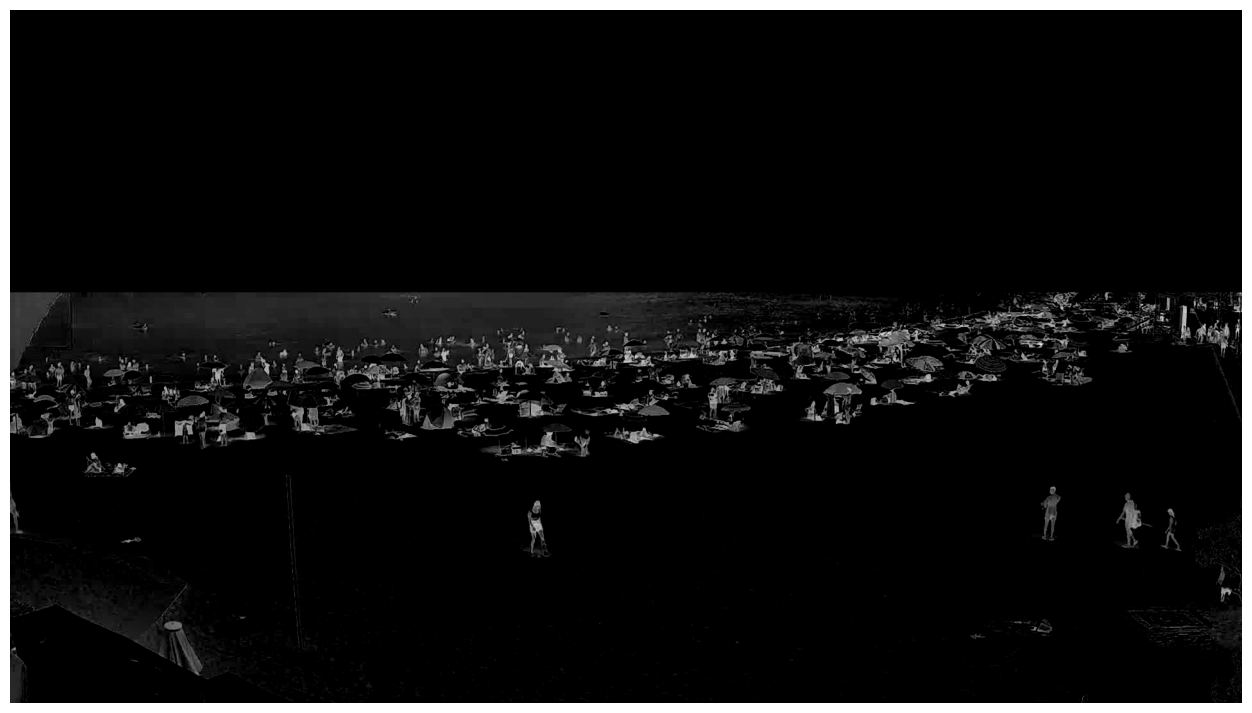

In [6]:

subs_image = cv2.subtract(empty_beach_9, test_image_1)

plt.imshow(subs_image, cmap = "gray")
plt.axis('off')

# TOPHAT

(-0.5, 1919.5, 1079.5, -0.5)

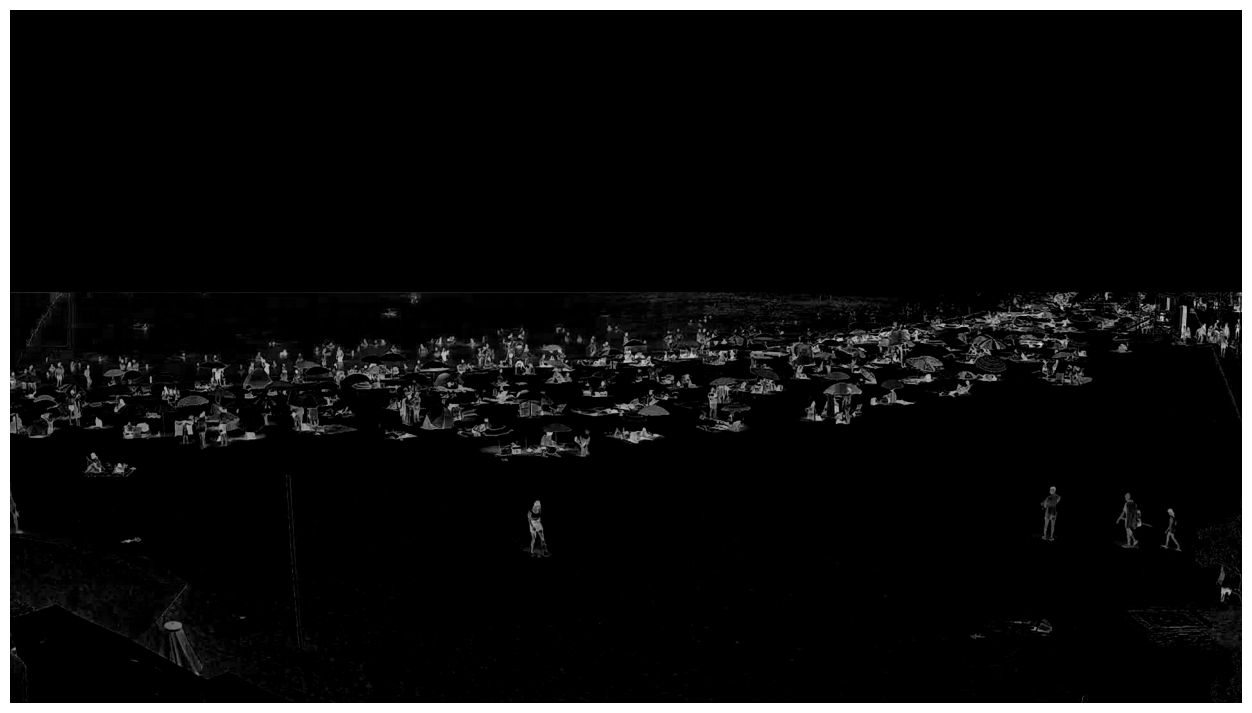

In [7]:
kernelSize = (10,18)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
tophat = cv2.morphologyEx(subs_image, cv2.MORPH_TOPHAT, kernel)

plt.imshow(tophat, cmap="gray")
plt.axis('off')

# READ COLOR DATASET

(1080, 1920, 10, 3)


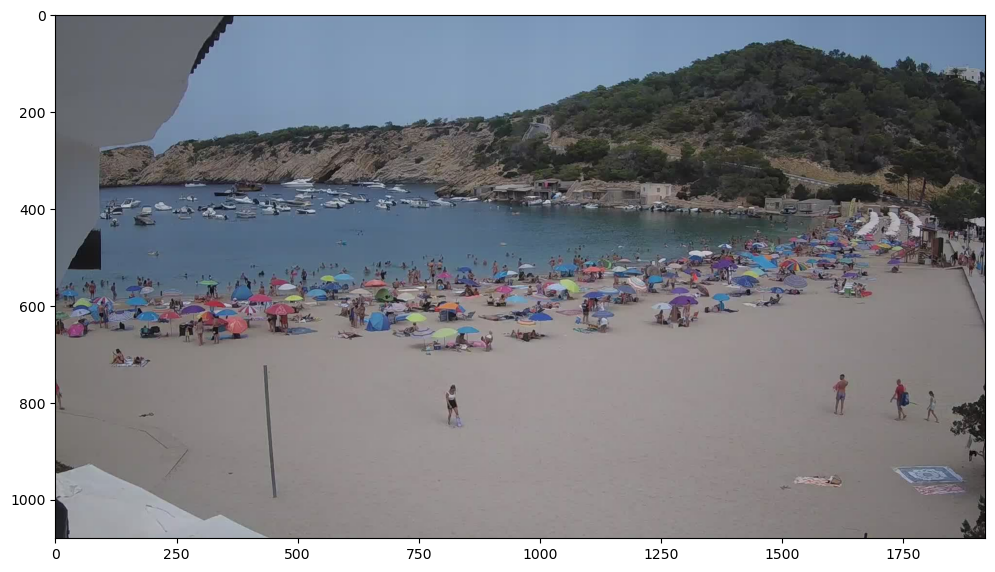

In [8]:
image_filenames = os.listdir("data")
for i in range(len(image_filenames)):
    image_filenames[i] = "data/" + image_filenames[i]

image_stack_color = np.stack([cv2.cvtColor(cv2.imread(filename),cv2.COLOR_RGB2BGR) for filename in image_filenames], axis=2)

print(image_stack_color.shape)
image_stack_color = np.transpose(image_stack_color, (2, 0, 1, 3))


fig = plt.figure(figsize=(12, 10))
plt.imshow(image_stack_color[4], cmap = "gray")

## Image sector divider

In [9]:
def min_max_norm(image):
    min_val = np.min(image)
    max_val = np.max(image)

    norm_image = (image - min_val) / (max_val - min_val)
    return norm_image


def divide_img_sectors(image):
    # Find boundaries
    
    img_size = image.shape
    sqrt_arr = np.sqrt(np.linspace(1,img_size[0],8, dtype = np.int_))
    norm_arr = min_max_norm(sqrt_arr)
    cut_boundaries = img_size[0] - (norm_arr * img_size[0]).astype(int)

    
    tmp = np.repeat(cut_boundaries, 2)[1:-1]
    cut_boundaries_paris = tmp[:(len(tmp) // 2 + 1) * 2].reshape(-1, 2)
    image_list_sectors = []

    for pair_i in cut_boundaries_paris:
        img = image[pair_i[1]:pair_i[0],:].copy()
        image_list_sectors.append(img)

    return image_list_sectors

## Find people by sector

In [10]:
def find_people_sec(image_list):
    p_sector_list = [None] * len(image_list)

    # FIRST SECTOR
    _, bin_0 = cv2.threshold(image_list[0], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_0 = cv2.dilate(bin_0,kernel_dil,iterations = 1)

    kernelSize_open = (6,8)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_0 = cv2.morphologyEx(bin_0, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (20,20)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_0 = cv2.morphologyEx(bin_0, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[0] = bin_0

    
    # SECOND SECTOR
    _, bin_1 = cv2.threshold(image_list[1], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_1 = cv2.dilate(bin_1,kernel_dil,iterations = 1)

    kernelSize_open = (5,7)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_1 = cv2.morphologyEx(bin_1, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (20,20)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_1 = cv2.morphologyEx(bin_1, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[1] = bin_1

    
    # THIRD SECTOR
    _, bin_2 = cv2.threshold(image_list[2], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_2 = cv2.dilate(bin_2,kernel_dil,iterations = 1)

    kernelSize_open = (2,2)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_2 = cv2.morphologyEx(bin_2, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (15,15)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_2 = cv2.morphologyEx(bin_2, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[2] = bin_2

    
    # FORTH SECTOR
    _, bin_3 = cv2.threshold(image_list[3], 30, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (2,2)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_3 = cv2.erode(bin_3,kernel_dil,iterations = 1)

    
    kernelSize_close = (8,12)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_3 = cv2.morphologyEx(bin_3, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_open = (5,5)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_3 = cv2.morphologyEx(bin_3, cv2.MORPH_OPEN, kernel_open)

    p_sector_list[3] = bin_3

    
    # FIFTH SECTOR
    _, bin_4 = cv2.threshold(image_list[4], 20, 255, cv2.THRESH_BINARY)

    kernelSize_open = (6,3)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_4 = cv2.morphologyEx(bin_4, cv2.MORPH_OPEN, kernel_open)


    kernelSize_close = (7,8)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_4 = cv2.morphologyEx(bin_4, cv2.MORPH_CLOSE, kernel_close)

    p_sector_list[4] = bin_4

    
    # SIXTH SECTOR
    _, bin_5 = cv2.threshold(image_list[5], 70, 255, cv2.THRESH_BINARY)

    kernelSize_close = (5,5)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_5 = cv2.morphologyEx(bin_5, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_open = (3,3)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_5 = cv2.morphologyEx(bin_5, cv2.MORPH_OPEN, kernel_open)

    p_sector_list[5] = bin_5

    
    # SEVENTH SECTOR
    _, bin_6 = cv2.threshold(image_list[6], 70, 255, cv2.THRESH_BINARY)

    kernelSize_close = (7,7)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_6 = cv2.morphologyEx(bin_6, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_dil = (4,4)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_6 = cv2.dilate(bin_6,kernel_dil,iterations = 1)

    p_sector_list[6] = bin_6

    return p_sector_list
        

## Find people 

In [11]:
def find_people(tophat_img):
    #Cut mountain, boats and sky
    image_cut = tophat_img[440:,:].copy()

    #Divide image in sectors
    img_sectors = divide_img_sectors(image_cut)

    # Find people, create the mask
    mask = np.zeros(image_cut.shape, dtype = np.uint8)

    p_sector_list = find_people_sec(img_sectors)

    # Unify image sectors
    mask_h = mask.shape[0]
    pos_h = 0
    
    for img in p_sector_list:
    
        top_h = mask_h - (pos_h + img.shape[0])
        bot_h = mask_h - (pos_h)
        mask[top_h:bot_h,:] = img
        pos_h += img.shape[0]

    return mask

## Compute people mask

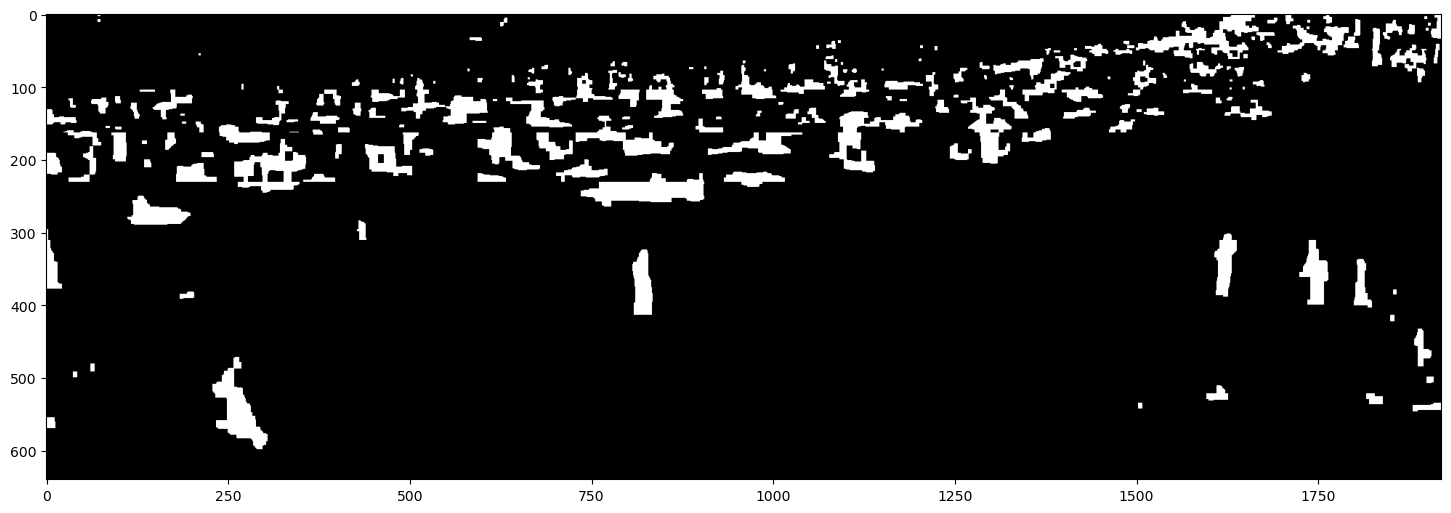

In [12]:
mask = find_people(tophat)
plt.imshow(mask, cmap = "gray")

## Compute gradient of mask

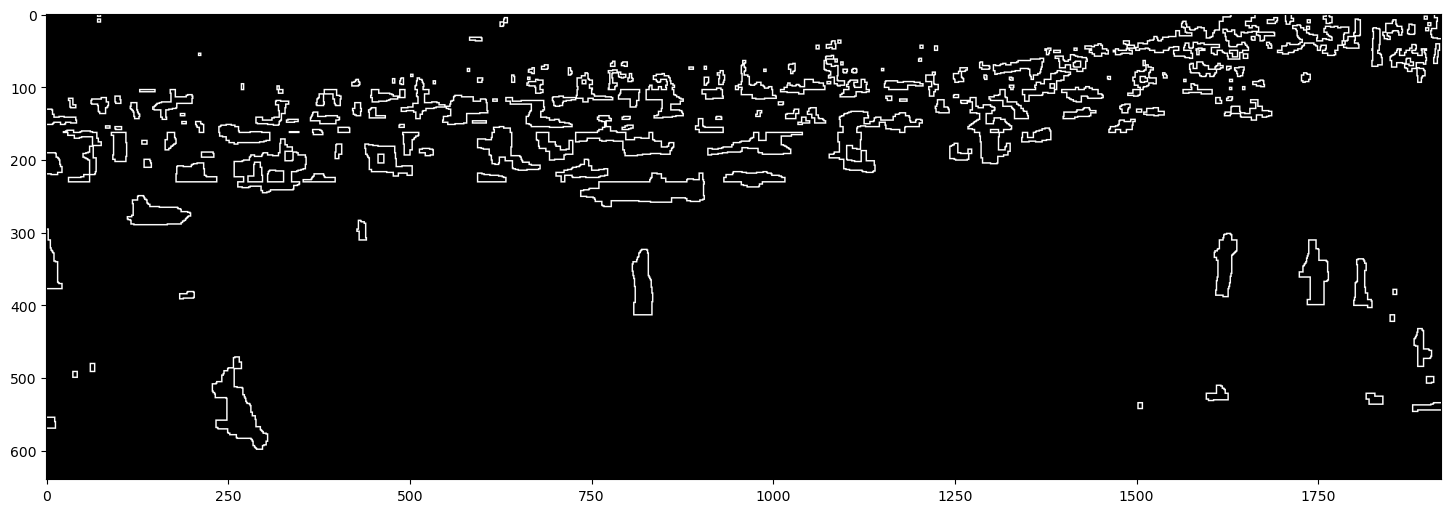

In [13]:
# Gradient of mask
kernelSize_close = (3,3)
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
people_gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel_close)

plt.imshow(people_gradient, cmap = "gray")

## Gradient over image

(-0.5, 1919.5, 1079.5, -0.5)

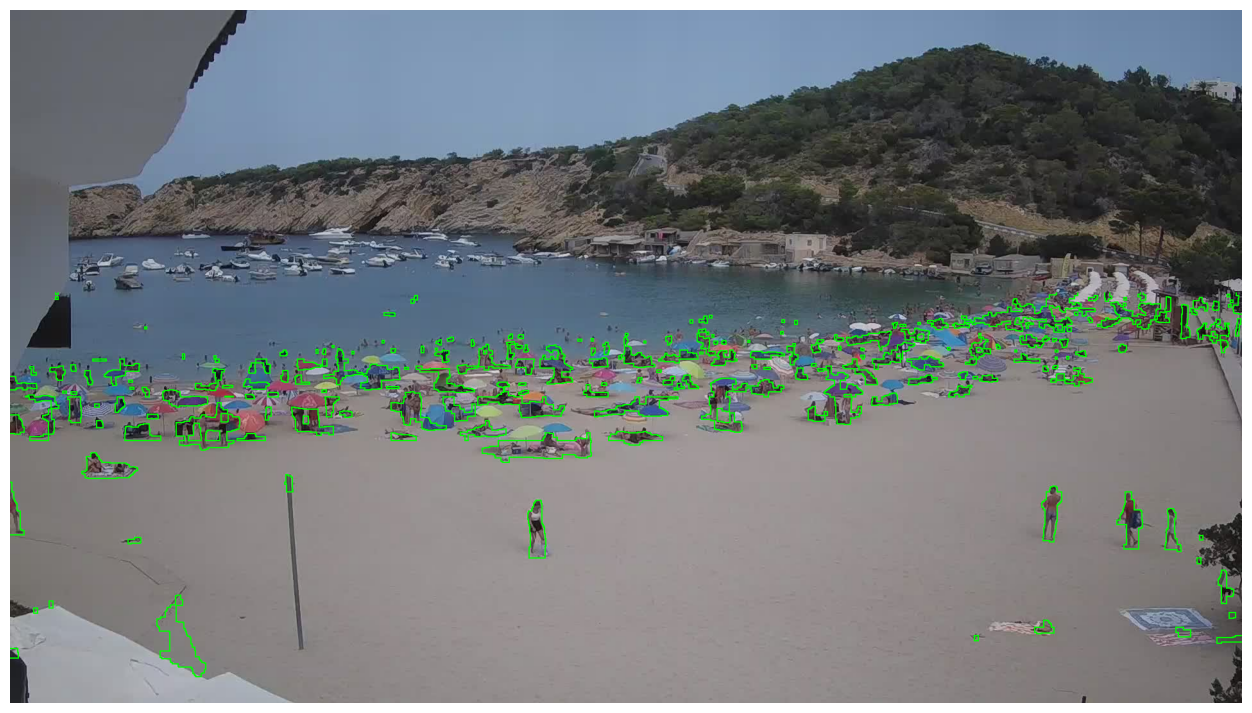

In [14]:
# Gradient over image
image_detected = image_stack_color[4].copy()

to_draw_bool = np.zeros(image_detected.shape[0:2], dtype=bool)

to_draw_bool[440:,:] = people_gradient == 255



image_detected[to_draw_bool] = (0,255,0)


plt.imshow(image_detected)
plt.axis('off')